# 1. Packages

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pickle

# 2. Download Asset Data

In [2]:
# List of 15 tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN', 'NFLX', 'NVDA', 'BABA', 'JPM', 'V', 'DIS', 'KO', 'PEP', 'NKE']

# Set the time horizon (start and end dates)
start_date = '2018-01-01'
end_date = '2023-01-01'

# Download historical data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

data.head()

[*********************100%***********************]  14 of 14 completed


Ticker,AAPL,AMZN,BABA,DIS,GOOGL,JPM,KO,MSFT,NFLX,NKE,NVDA,PEP,TSLA,V
Date,,,,,,,,,,,,,,
2018-01-02 00:00:00+00:00,40.568928,59.450500,177.359360,107.875183,53.527954,89.109093,37.069424,79.792885,201.070007,58.950073,4.930642,96.932854,21.368668,109.311722
2018-01-03 00:00:00+00:00,40.561863,60.209999,177.697372,108.338326,54.441196,89.199898,36.988022,80.164253,205.050003,58.940773,5.255148,96.678337,21.150000,110.399979
2018-01-04 00:00:00+00:00,40.750267,60.479500,179.348816,108.290085,54.652668,90.477745,37.508984,80.869843,205.630005,58.903648,5.282848,97.154549,20.974667,110.810478
2018-01-05 00:00:00+00:00,41.214233,61.457001,184.167877,107.701485,55.377377,89.896904,37.500847,81.872467,209.990005,59.405033,5.327616,97.433708,21.105333,113.464279
2018-01-08 00:00:00+00:00,41.061146,62.343498,183.810547,106.157669,55.572891,90.029663,37.443871,81.956009,212.050003,59.934273,5.490860,96.875389,22.427334,113.922470


In [4]:
# locally saved data
with open('./downloaded.pkl', 'wb') as file:
    pickle.dump(data, file)

# 3. Calculate Daily Returns

In [6]:
returns = data.pct_change().dropna()

# Risk-free rate (for Sharpe Ratio, e.g., 2% annualized)
risk_free_rate = 0.02

# Calculate annualized returns and volatility
mean_returns = returns.mean() * 252  # 252 trading days in a year
volatility = returns.std() * 252

# Sharpe ratio = (mean return - risk-free rate) / volatility
sharpe_ratios = (mean_returns - risk_free_rate) / volatility

# Sort by Sharpe ratio (from highest to lowest)
sorted_sharpe = sharpe_ratios.sort_values(ascending=False)

# Get the top 5 tickers based on the Sharpe Ratio
top_5_tickers = sorted_sharpe.head(5)
print("Top 5 tickers based on Sharpe Ratio:", top_5_tickers)

Top 5 tickers based on Sharpe Ratio: Ticker
TSLA    0.052404
AAPL    0.050316
MSFT    0.049902
NVDA    0.040430
PEP     0.033816
dtype: float64


['TSLA', 'AAPL', 'MSFT', 'NVDA', 'PEP']

In [12]:
# Top tickers data
top_tickers = top_5_tickers.index.to_list()
top_data = data[top_tickers]
top_returns = top_data.pct_change().dropna()

# 4. Mean-Variance Optimization (Modern Portfolio Theory)

In [13]:
def portfolio_performance(weights, mean_returns, cov_matrix) -> tuple:
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate) -> float:
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Minimize the negative Sharpe ratio

def optimize_portfolio(mean_returns, cov_matrix, tickers, risk_free_rate=0) -> ...:
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0.10, 0.50) for _ in range(num_assets))
    initial_weights = np.array([1/len(tickers)] * len(tickers))
    
    result = minimize(
        negative_sharpe, initial_weights, args=args,
        method='SLSQP', bounds=bounds, constraints=constraints
    )
    return result

# 5. Optimize the Portfolio

In [14]:
# Calculate mean returns and covariance matrix
mean_returns = top_returns.mean() * 252
cov_matrix = top_returns.cov() * 252

# Optimize portfolio
optimal_result = optimize_portfolio(mean_returns, cov_matrix, top_tickers, risk_free_rate)
optimal_weights = optimal_result.x

# 6. Visualize the Efficient Frontier

In [15]:
def generate_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_stddev = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stddev  # Sharpe Ratio
    
    return results, weights_record

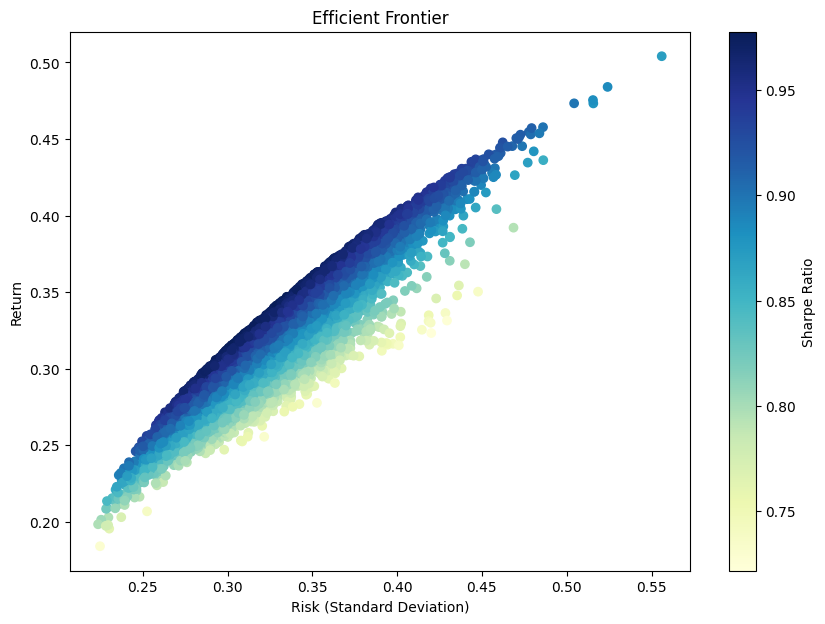

In [16]:
# Generate portfolios
num_portfolios = 10000
results, weights = generate_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

# Plot Efficient Frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


# 7. Analyze the Optimal Portfolio

In [17]:
opt_return, opt_std = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
print("Optimal Portfolio Weights:", optimal_weights)
print("Expected Portfolio Return:", opt_return)
print("Expected Portfolio Risk (Standard Deviation):", opt_std)

Optimal Portfolio Weights: [0.27823234 0.2438065  0.16759891 0.1        0.21036225]
Expected Portfolio Return: 0.3364778811498317
Expected Portfolio Risk (Standard Deviation): 0.32734146085000654
